# MÁS FEATURE ENGINEERING

## VARIABLES TEMPORALES

<img src="clocks.png" align="center" width="70%"/>

Particularidades de las variables circulares:
- La hora del día es cíclica por naturaleza, lo que significa que los valores al final del día están relacionados con los valores al principio del día siguiente. Si le aplicáramos un tratamiento lineal a estas variables numéricas, obtendríamos resultados engañosos o inexactos.<br><br>
- La hora del día puede estar relacionada con otras variables, como el día de la semana o la estación. Por ejemplo, puede haber más tráfico en una hora pico en un día de semana que en un fin de semana.

1    2020-01-01 03:09:57
6    2020-01-01 16:37:52
9    2020-01-01 19:16:12
12   2020-01-01 19:16:58
15   2020-01-01 19:17:48
Name: date, dtype: datetime64[ns]
count                              349
mean     2020-04-03 01:32:31.352435712
min                2020-01-01 03:09:57
25%                2020-02-09 08:44:55
50%                2020-03-27 01:00:01
75%                2020-05-25 00:36:32
max                2020-07-29 22:39:35
Name: date, dtype: object


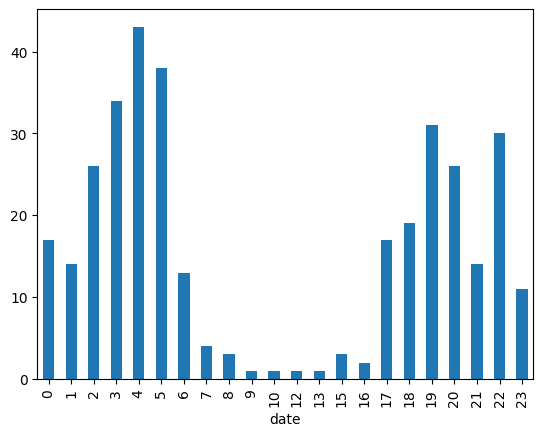

In [1]:
import pandas as pd
import pycircular
import matplotlib.pyplot as plt
from IPython.display import display, HTML

df = pycircular.datasets.load_transactions()['data']
df['date']= pd.to_datetime(df['date'])
dates = df.loc[df['user'] == 1, 'date']

print(dates.head())
print(dates.describe())

dates.groupby(dates.dt.hour).count().plot(kind="bar");

Utilizamos la librería pycircular para plotear en gráficos circulares la hora, el día de la semana y el día del mes.

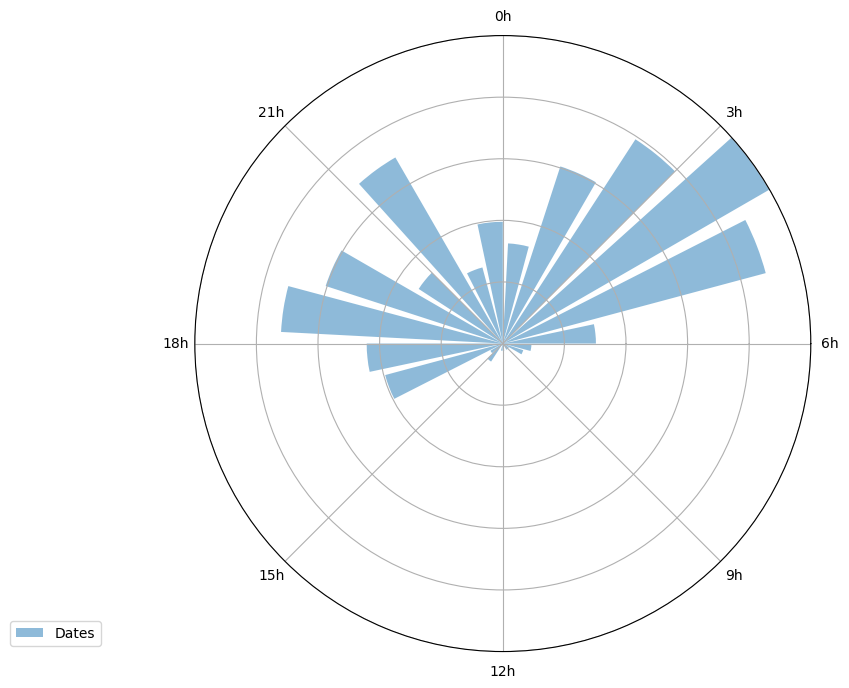

In [26]:
time_segment = 'hour'  
freq_arr, times = pycircular.utils.freq_time(dates , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

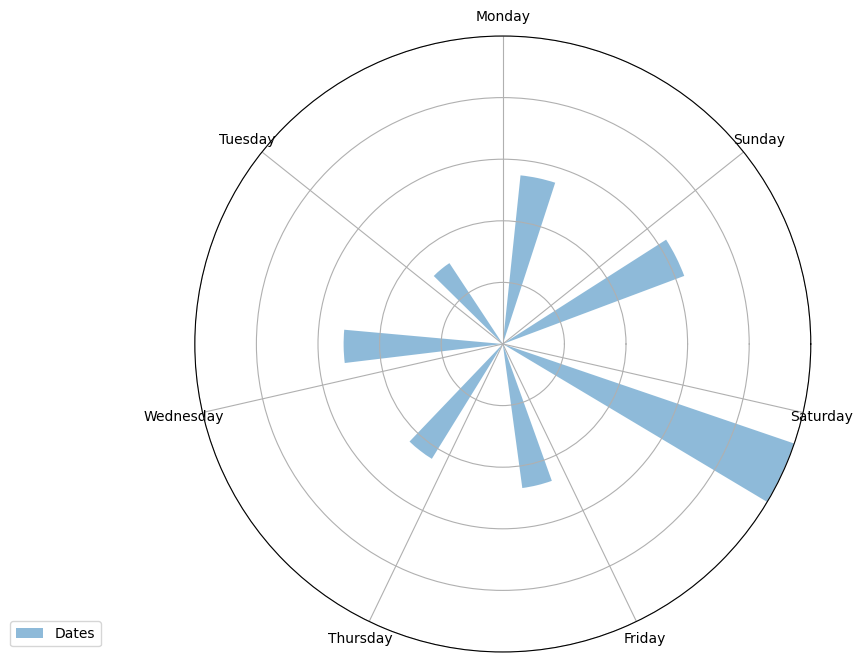

In [27]:
time_segment = 'dayweek'  
freq_arr, times = pycircular.utils.freq_time(dates , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

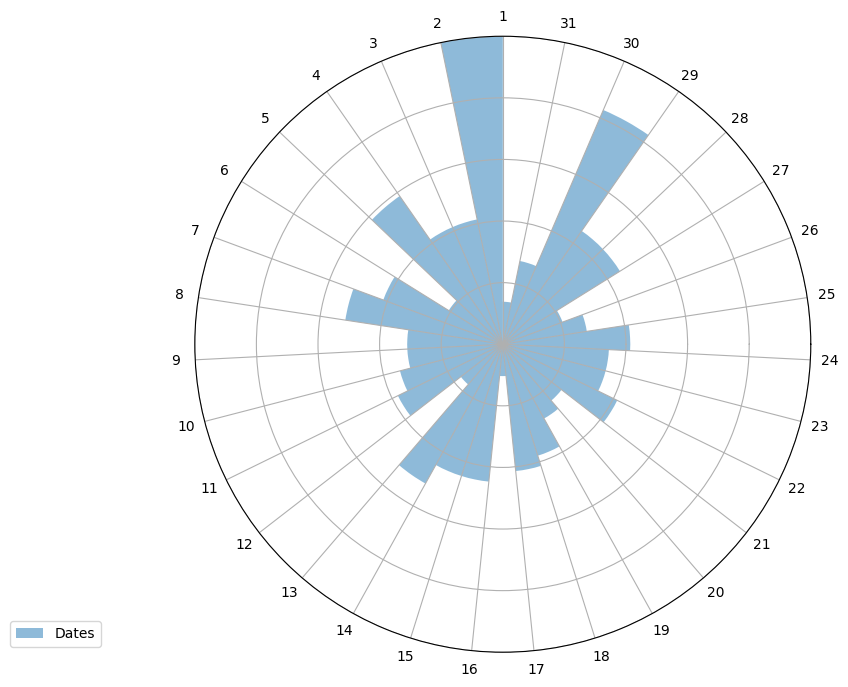

In [25]:
time_segment = 'daymonth'  
freq_arr, times = pycircular.utils.freq_time(dates , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Volvamos al gráfico por horas... ¿qué pasaría si calculamos la **media aritmética** como si se tratara de una variable numérica convencional? ¿Tiene sentido usar esta medida?

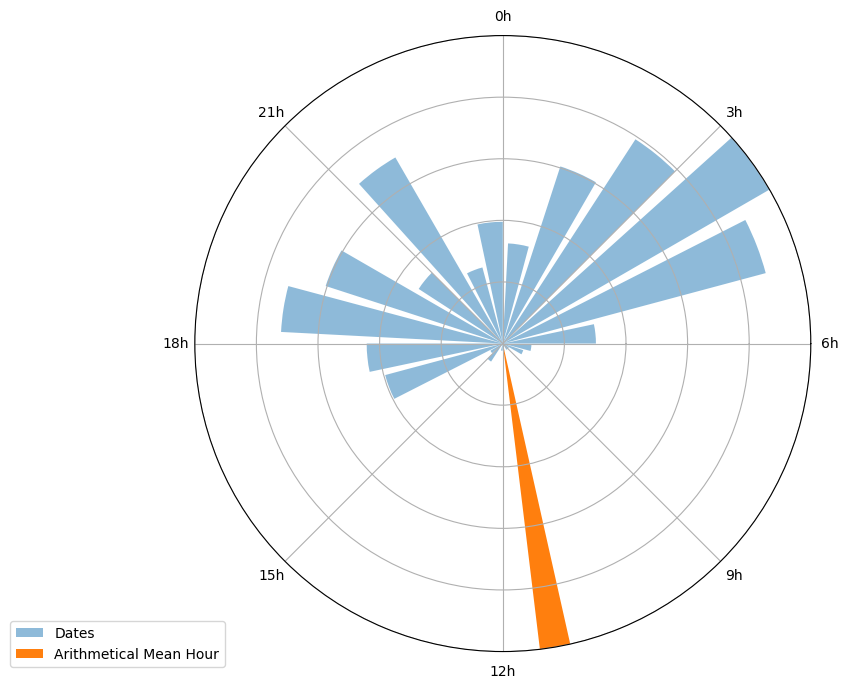

In [3]:
dates_mean = times.values.mean()
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.bar([dates_mean], [1], width=0.1, label='Arithmetical Mean Hour')
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

**La media aritmética no tiene sentido en este caso.**
Por ej, si tuvieramos cuatro transacciones con horas 2:00, 3:00, 22:00 and 23:00, la media es 12:30, no cual no nos da información útil sobre este conjunto de datos.
<br><br>
Una alternativa es utlizar la distribución de **Von Mises**, también conocida como la distribución normal periódica.

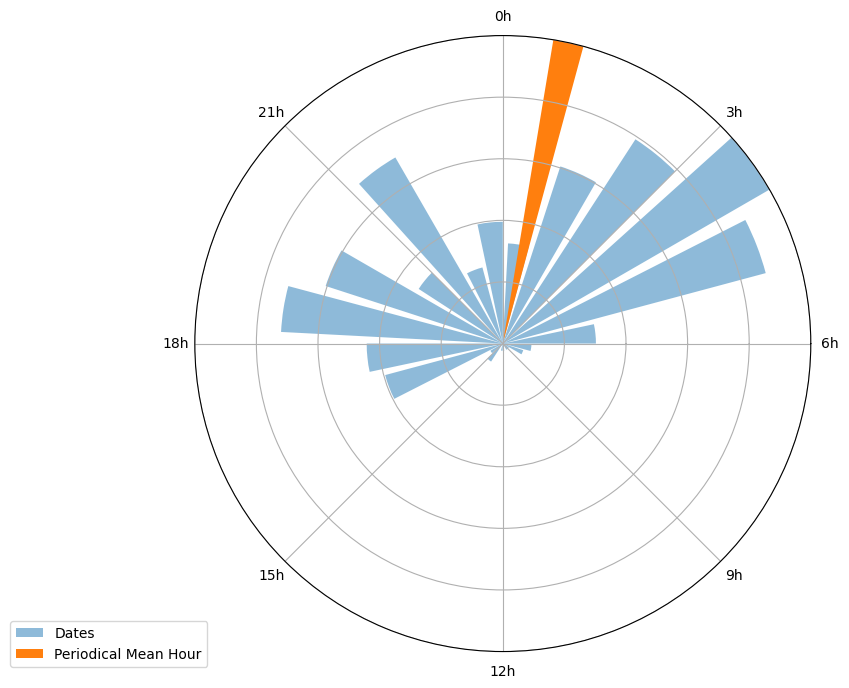

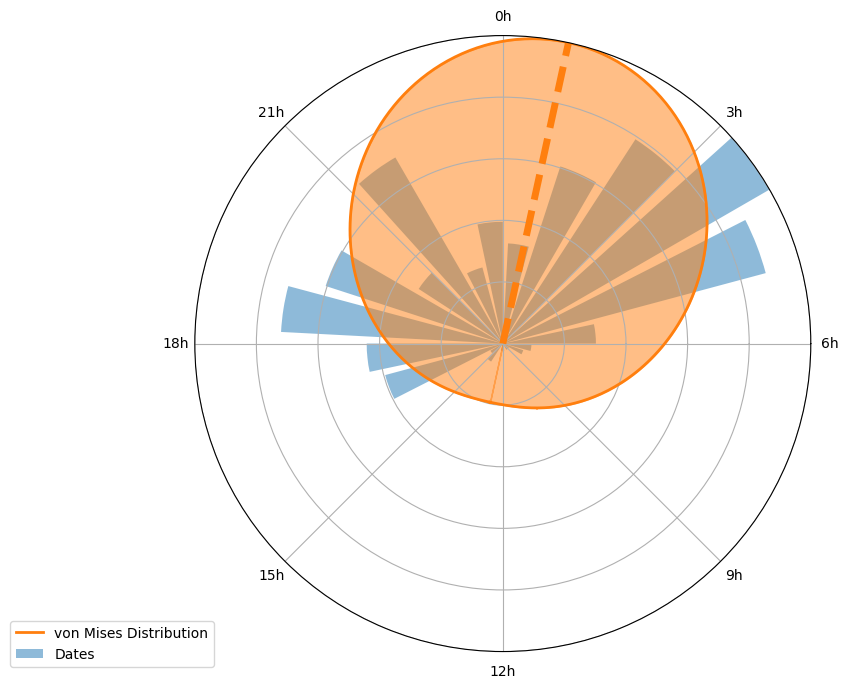

In [4]:
#Calculamos la media periódica. 
radians = pycircular.utils._date2rad(dates, time_segment='hour')
mean, std = pycircular.stats.periodic_mean_std(radians)

fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.bar([mean], [1], width=0.1, label='Periodical Mean Hour')
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

x, p = pycircular.stats.von_mises_distribution(mean, std)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment='hour')

ax1 = pycircular.plots.clock_vonmises_distribution(ax1, mean, x, p)
plt.show()

A partir de esta distribución, podemos generar una estimación de densidad de kernel:

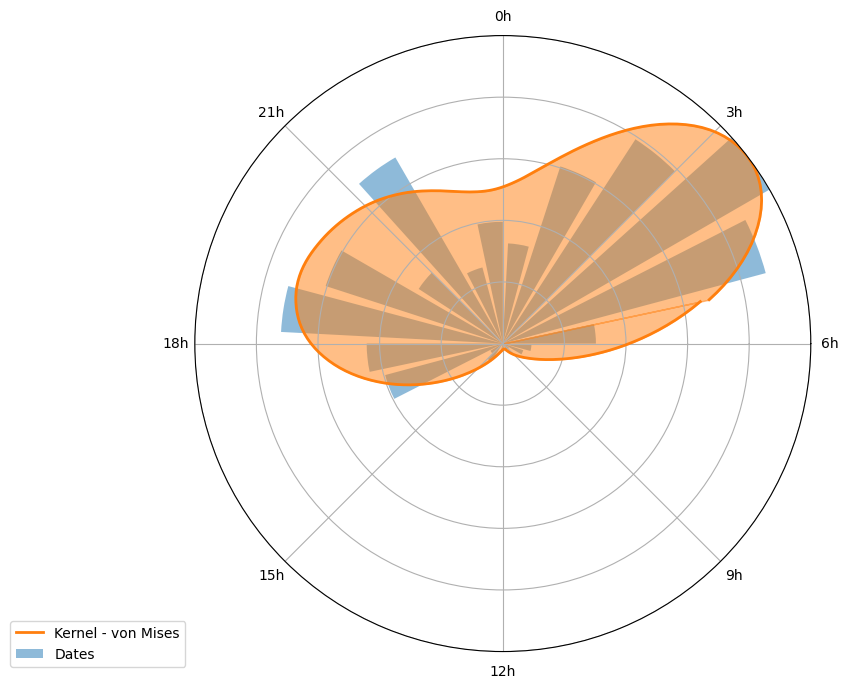

In [5]:
y = pycircular.circular.kernel(radians.values)

fig, ax1 = pycircular.plots.plot_kernel(freq_arr[:, 0], freq_arr[:, 1], y,time_segment=time_segment)


Y a partir de este kernel, podemos estimar la probabilidad de un registro nuevo de obtener cierto valor. De esta manera, ¡generamos **una nueva feature** que podemos utilizar en un modelo de machine-learning, y que no sufre de los inconvenientes de la variable circular original!
<br><br>
Vemos en el ejemplo que un registro con la hora 3:00 tiene una alta probabilidad, uno a las 18:00 tiene una probabilidad media, mientras que uno a las 12:00 tiene una probabilidad muy baja, dado que hubo muy pocos registros en las horas aledañas al momento de entrenar el kernel.

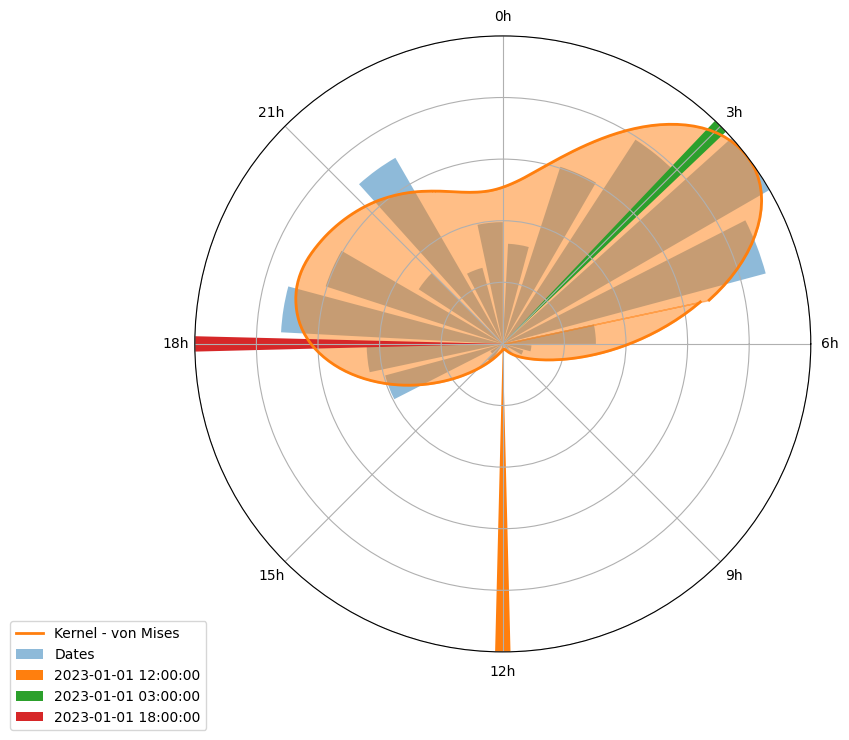

In [6]:
y_test = pd.DataFrame(pd.to_datetime([
    '2023-01-01 12:00:00',
    '2023-01-01 03:00:00',
    '2023-01-01 18:00:00',
    ]), columns=['dates'])

radians = pycircular.utils._date2rad(y_test['dates'], time_segment='hour')
y_test['prob'] = pycircular.circular.predict_proba(radians, y)

display(HTML(y_test.to_html()))

fig, ax1 = pycircular.plots.plot_kernel(freq_arr[:, 0], freq_arr[:, 1], y,time_segment=time_segment)

for i in range(y_test.shape[0]):
    ax1.bar([radians[i]], [1], width=0.05, label=y_test.loc[i, 'dates'])
    
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0);

NOTA: recordar que en el contexto de un modelo de aprendizaje supervisado, si quisiéramos utilizar este tipo de transformación sobre variables temporales, deberíamos hacer un ajuste inicial (fit-transform) sobre los datos de entrenamiento para luego aplicar las variables transformadas sobre los datos de prueba (transform). Es decir, si las 12h de los datos de entrenamiento se representan con un valor de 0.017, lo mismo deberíamos hacer con los datos de prueba.

## Más despacio cerebrito... utilizando funciones más sencillas

<img src="cerebrito.png" align="center" width="40%"/>

Combinando las funciones **seno y coseno** podemos caracterizar una variable cíclica, a partir de dos features que pueden ser input de un modelo de machine learning.

Recordemos que el Seno, Coseno y Tangente son, cada una, una proporción de los lados de un triángulo rectángulo:

<img src="sin-cos-tan.svg" align="center" width="100%"/>

Si llevaramos esta lógica a los 360°, tendríamos que:

Seno
- 0°: 0
- 90°: 1
- 180°: 0
- 270°: -1
- 360°: 0

Coseno:
- 0°: 1
- 90°: 0
- 180°: -1
- 270°: 0
- 360°: 1

<img src="sen-cos.png" align="center" width="50%"/>

O viéndolo en radianes:

<img src="radianes.jpg" align="center" width="50%"/>

¡Atención! Pensando en un reloj de 24h, la hora 0 tendría un ángulo de 0°, es decir con seno=0 y coseno=1 (=0π). El ángulo y los radianes van incrementando en el sentido de las agujas del reloj (a la derecha).

Es decir que la función seno toma los valores:
- 0hs (0°, 0π): 0
- 6hs (90°, 1/2π): 1
- 12hs (180°, π): 0
- 18hs (270°, 3/2π): -1
- 24hs (360°, 2π): 0

Mientras que la función coseno toma los valores:
- 0hs (0°, 0π): 1
- 6hs (90°, 1/2π): 0
- 12hs (180°, π): -1
- 18hs (270°, 3/2π): 0
- 24hs (360°, 2π): 1


In [7]:
import numpy as np
import math
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

df = pd.DataFrame(index=pd.date_range(start='6/1/2020', end='6/2/2020', freq='min')[:-1])

#Completamos con número de minutos
df["x"]=np.linspace(0, 24 * 60 - 1, 24 * 60, dtype=int)

#Llevamos los minutos a radianes. Es decir, queremos representar nuestras variables temporales (horas, días, meses, etc)
#en el rango [0,2*Pi]
df["x_norm"] = 2 * math.pi * df["x"] / df["x"].max()
df["hora"] = df['x']/60
df["cos_x"] = np.cos(df["x_norm"])
df["sin_x"] = np.sin(df["x_norm"])

display(df)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.hora, y=df.cos_x,name="Coseno"))
fig.add_trace(go.Scatter(x=df.hora, y=df.sin_x,name="Seno"))

fig.show()

x    x_norm       hora     cos_x         sin_x
2020-06-01 00:00:00     0  0.000000   0.000000  1.000000  0.000000e+00
2020-06-01 00:01:00     1  0.004366   0.016667  0.999990  4.366341e-03
2020-06-01 00:02:00     2  0.008733   0.033333  0.999962  8.732600e-03
2020-06-01 00:03:00     3  0.013099   0.050000  0.999914  1.309869e-02
2020-06-01 00:04:00     4  0.017465   0.066667  0.999847  1.746453e-02
...                   ...       ...        ...       ...           ...
2020-06-01 23:55:00  1435  6.265720  23.916667  0.999847 -1.746453e-02
2020-06-01 23:56:00  1436  6.270086  23.933333  0.999914 -1.309869e-02
2020-06-01 23:57:00  1437  6.274453  23.950000  0.999962 -8.732600e-03
2020-06-01 23:58:00  1438  6.278819  23.966667  0.999990 -4.366341e-03
2020-06-01 23:59:00  1439  6.283185  23.983333  1.000000 -2.449294e-16

[1440 rows x 5 columns]

Podemos observar por el gráfico que utilizando ambas variables podemos saber en qué momento del ciclo nos encontramos. Además, el final del ciclo se encadena con el principio del ciclo siguiente, lo que connota la propiedad de continuidad que estabamos buscando.

In [31]:
#Llevamos la hora a segundos
timestamp_s = dates.map(pd.Timestamp.timestamp)

#Tenemos en cuenta el valor máximo en segundos para el cálculo de las funciones seno y coseno
dia_segundos = 24*60*60

#Llevamos los segundos a proporción de 2π (círculo de 360°) y calculamos seno y coseno
hora_seno=np.sin(2*math.pi*(timestamp_s/dia_segundos))
hora_coseno=np.cos(2*math.pi*(timestamp_s/dia_segundos))

print(hora_seno)
print(hora_coseno)

1      0.737130
6     -0.936468
9     -0.945234
12    -0.944137
15    -0.942932
         ...   
91    -0.959601
94    -0.543663
97    -0.272350
104    0.623254
108   -0.343728
Name: date, Length: 349, dtype: float64
1      0.675751
6     -0.350752
9      0.326393
12     0.329553
15     0.332984
         ...   
91     0.281365
94     0.839304
97     0.962198
104    0.782019
108    0.939069
Name: date, Length: 349, dtype: float64


In [9]:
#Alternativa: con esta función pasamos una fecha/hora y nos devuelve cada variable temporal codificada en seno/coseno
from datetime import datetime
from math import sin, cos, pi

days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

def sin_cos(n):
    theta = 2 * pi * n
    return (sin(theta), cos(theta))

def get_cycles(d):
    '''
    Get the cyclic properties of a datetime,
    represented as points on the unit circle.
    Arguments
    ---------
    d : datetime object
    Returns
    -------
    dictionary of sine and cosine tuples
    '''
    month = d.month - 1
    day = d.day - 1
    return {
        'month': sin_cos(month / 12),
        'day': sin_cos(day / days_in_month[month]),
        'weekday': sin_cos(d.weekday() / 7),
        'hour': sin_cos(d.hour / 24),
        'minute': sin_cos(d.minute / 60),
        'second': sin_cos(d.second / 60)
    }


get_cycles(datetime(2018, 6, 3, 16, 51, 53))


{'month': (0.49999999999999994, -0.8660254037844387),
 'day': (0.40673664307580015, 0.9135454576426009),
 'weekday': (-0.7818314824680299, 0.6234898018587334),
 'hour': (-0.8660254037844385, -0.5000000000000004),
 'minute': (-0.8090169943749476, 0.5877852522924729),
 'second': (-0.6691306063588588, 0.7431448254773937)}

## VARIABLES HISTÓRICAS

Si tenemos una serie de variables numéricas agrupadas temporalmente a partir de días, semanas, meses o años, podemos pensar en un conjunto de nuevas variables, como ser:
- mínimo
- máximo
- media
- suma (en el caso de que se traten de variables stock o cantidades). Por ej, nos sirve para una cantidad producida o ventas, pero no para un índice inflacionario.
- variación intermensual
- establecer una **regresión lineal**, a partir de la cual obtener la **tendencia** y el **error** o diferencia de cada momento temporal respecto a esta predicción. Hay que tener en cuenta que este proceso puede ser demandante en capacidad de cálculo, sobre todo en datasets con muchos registros. Por otro lado, podríamos utilizar otro tipo de regresión (cuadrática, polinómica, etc), si inferimos que los datos siguen este comportamiento.

In [10]:
def ajustar_reg_mat(X_mat,y):
    Y=np.array(y)
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y)
    return(beta_hat)

def calculo_vars_hist(df,vars_hist_aux,vars_hist_cant_aux,vars_reg_aux,periodos_hist_aux,sufijo):
    
    """
    vars_hist_aux: lista de variables históricas mensuales. Estas variables deben estar identificadas por el 
    sufijo "_M"+<núm de mes>: M1, M2, etc.. Hay que indicar el nombre genérico de la variable (sin el sufijo). Por ejemplo: 
        ['cant_est','cant_pres','aceptacion','transacciones','volumen']. La función identifica todas las variables
        mensuales correspondientes, por ej, para cant_est, identifica cant_est_M1, cant_est_M2, cant_est_M3, etc..
    vars_hist_cant_aux: lista de variables históricas referidas a cantidades, para las cuales corresponde 
        calcular la suma. Por ejemplo, no corresponde indicar "aceptacion", por tratarse de una variable de proporción. Es decir, 
        indicaríamos:    ['cant_est','cant_pres','transacciones','volumen'].
    vars_reg_aux: lista de variables para las cuales se ajustaran regresiones lineales, y se calculará la tendencia y 
        los errores cuadráticos. Tener en cuenta que este cálculo es costoso computacionalmente (demora aprox 10 segundos por 
        cada 10k registros por variable ajustada), por lo que es conveniente especificar solo algunas variables relevantes. 
        Ejemplo:       ['transacciones','volumen'].
    periodos_hist_aux: entero correspondiente a cantidad de períodos mensuales. Por ejemplo, 6.
    sufijo: sufijo que tienen las variables mensuales (para poder identificarlas)
    """  
    
    df2=df.copy()
    
    for i in range(len(vars_hist_aux)):
        aux=pd.Series(df2.columns)
        cols=list(aux[aux.str.contains(vars_hist_aux[i]+sufijo)])

        for k in range(periodos_hist_aux-1):
            filtro=df2.loc[:,cols[k+1]].isnull() | df2.loc[:,cols[k]].isnull() | (df2.loc[:,cols[k+1]]==0)
            aux_val=round((df2.loc[-filtro,cols[k]]/df2.loc[-filtro,cols[k+1]]-1).astype('float'),3)
            nom_col=cols[k]+'_var'
            df2.loc[filtro,nom_col]=np.nan
            df2.loc[-filtro,nom_col]=aux_val

        promedio=df2.loc[:,cols].mean(axis=1)
        maximo=df2.loc[:,cols].max(axis=1)
        minimo=df2.loc[:,cols].min(axis=1)

        #Solo calculamos la suma para las variables de cantidades
        if vars_hist_aux[i] in vars_hist_cant_aux:
            suma=df2.loc[:,cols].sum(axis=1)
            nuevas_vars=pd.concat([suma,promedio,maximo,minimo],axis=1)
            nuevas_vars.columns=[vars_hist_aux[i]+'_suma',vars_hist_aux[i]+'_promedio',vars_hist_aux[i]+'_max',vars_hist_aux[i]+'_min']
        else:
            nuevas_vars=pd.concat([promedio,maximo,minimo],axis=1)
            nuevas_vars.columns=[vars_hist_aux[i]+'_promedio',vars_hist_aux[i]+'_max',vars_hist_aux[i]+'_min']

        if vars_reg_aux!=None and vars_hist_aux[i] in vars_reg_aux:
            #Para regresión

            #Completamos nulos para regresión
            aux_reg=df2.loc[:,cols].apply(lambda x:x.interpolate(),axis=1)
            aux_reg=aux_reg.apply(lambda x:x.ffill(),axis=1)
            aux_reg=aux_reg.apply(lambda x:x.bfill(),axis=1)
            aux_reg=aux_reg.apply(pd.to_numeric, errors = 'coerce')
            
            #Forma rápida para hacer muchas regresiones juntas
            X_mat=np.vstack((np.ones(periodos_hist_aux), np.array(range(periodos_hist_aux))+1)).T
            regs=aux_reg.apply(lambda y:ajustar_reg_mat(X_mat,y),axis=1)
            regs_df=pd.DataFrame(np.vstack(regs))
            coefs=round(regs_df[1],3)
            x=np.tile((np.array(range(periodos_hist_aux))+1),(len(df2),1))
            preds=np.array(regs_df[0]).reshape(-1,1)+np.array(regs_df[1]).reshape(-1,1)*(x)
            errores=round((preds-aux_reg)**2,3)

            nuevas_vars_reg=pd.concat([coefs,errores],axis=1)
            nuevas_vars_reg.columns=[vars_hist_aux[i]+'_tend']+[vars_hist_aux[i]+'_err'+sufijo+str(x+1) for x in range(periodos_hist_aux)]
            nuevas_vars=pd.concat([nuevas_vars,nuevas_vars_reg],axis=1)
    res=pd.concat([df2,nuevas_vars],axis=1)
    return(res)

In [11]:
df=pd.DataFrame({'prod_M1':[30,10,20,40],'prod_M2':[25,14,23,48],'prod_M3':[23,18,29,49],'prod_M4':[28,19,39,44]})
df

prod_M1  prod_M2  prod_M3  prod_M4
0       30       25       23       28
1       10       14       18       19
2       20       23       29       39
3       40       48       49       44

In [12]:
df2=calculo_vars_hist(df,vars_hist_aux=['prod'],vars_hist_cant_aux=['prod'],vars_reg_aux=['prod'],periodos_hist_aux=4,sufijo='_M')
df2    

prod_M1  prod_M2  prod_M3  prod_M4  prod_M1_var  prod_M2_var  prod_M3_var  \
0       30       25       23       28        0.200        0.087       -0.179   
1       10       14       18       19       -0.286       -0.222       -0.053   
2       20       23       29       39       -0.130       -0.207       -0.256   
3       40       48       49       44       -0.167       -0.020        0.114   

   prod_suma  prod_promedio  prod_max  prod_min  prod_tend  prod_err_M1  \
0        106          26.50        30        23       -0.8         5.29   
1         61          15.25        19        10        3.1         0.36   
2        111          27.75        39        20        6.3         2.89   
3        181          45.25        49        40        1.3        10.89   

   prod_err_M2  prod_err_M3  prod_err_M4  
0         3.61         9.61         7.29  
1         0.09         1.44         0.81  
2         2.56         3.61         3.24  
3        11.56         9.61        10.24

[-0.8]
28.5


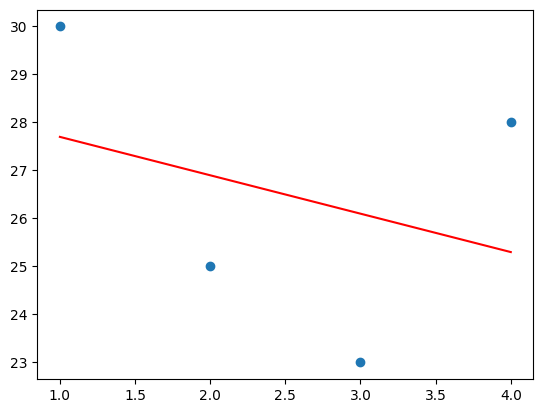

In [13]:
#Verificamos regresión para el primer registro

from sklearn.linear_model import LinearRegression

X=(np.array(range(4))+1).reshape(-1,1)
y=np.array(df.iloc[0])
reg = LinearRegression().fit(X, y)
print(reg.coef_)
print(reg.intercept_)
yhat=reg.predict(X)

plt.scatter(X, y)
plt.plot(X, yhat, color='red');

## PRÁCTICA EN CLASE

A partir del df c2_fe_hist.csv, entrenar dos modelos:
1. Uno con las variables originales
2. Otro aplicando las técnicas de feature engineering vistas, tanto para variables históricas como para variables temporales

In [14]:
#Recomendamos utilizar las siguientes librerías

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from scipy import stats

#Parámetros sugeridos para RandomizedSearchCV
param_dist = {'max_depth': stats.randint(1,50),
              'learning_rate': stats.uniform(0.01, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }

df_gen=pd.read_csv('data/c2_fe_hist.csv')
df_gen

ventas_M1  ventas_M2  ventas_M3  ventas_M4  ventas_M5  ventas_M6  \
0         1062       1020       1060       1270       1201       1351   
1          458        555        576        821       1107       1128   
2          558        189        246        171        185        417   
3          302        326        556        647        637        740   
4          333        731        489        695        718       1001   
..         ...        ...        ...        ...        ...        ...   
995        527        583        660        699        594        912   
996        164        248        125         94          0          0   
997        362        729        552        778        924        883   
998        587        766        910        904        995        968   
999         92        283        137          0          0          0   

     ventas_M7  ventas_M8  ventas_M9  ventas_M10  ventas_M11  ventas_M12  \
0         1320       1542       1389        1336        1521        1600   
1         1275       1183       1152        1507        1270        1594   
2          410        404        249         142          65          80   
3          668        990        914        1084        1142        1194   
4          982        751       1181        1138        1085        1238   
..         ...        ...        ...         ...         ...         ...   
995        911        882        968        1325        1285        1530   
996          0          0          0           0           0           0   
997       1027        912       1129        1250        1183        1224   
998       1047       1214       1439        1521        1653        1694   
999          0          0          0           0           0           0   

          fecha  y  
0    2022-12-11  1  
1    2022-12-11  1  
2    2023-01-27  0  
3    2023-02-02  1  
4    2023-01-27  1  
..          ... ..  
995  2023-01-27  1  
996  2022-12-11  1  
997  2023-02-02  1  
998  2023-02-02  1  
999  2023-02-02  0  

[1000 rows x 14 columns]

## SOLUCIÓN

In [15]:
df_gen=pd.read_csv('data/c2_fe_hist.csv')
df_gen['fecha']=pd.to_datetime(df_gen['fecha'])

In [16]:
#Tenemos en cuenta el valor máximo en segundos para el cálculo de las funciones seno y coseno
cant_meses=12

mes_seno=np.sin((df_gen.fecha.dt.month*(2*math.pi/cant_meses)))
mes_coseno=np.cos((df_gen.fecha.dt.month*(2*math.pi/cant_meses)))

df_gen['mes_seno']=mes_seno
df_gen['mes_coseno']=mes_coseno
df_gen.drop(columns=['fecha'],inplace=True)

df_gen2=calculo_vars_hist(df_gen,vars_hist_aux=['ventas'],vars_hist_cant_aux=['ventas'],vars_reg_aux=['ventas'],periodos_hist_aux=12,sufijo='_M')
df_gen2

ventas_M1  ventas_M2  ventas_M3  ventas_M4  ventas_M5  ventas_M6  \
0         1062       1020       1060       1270       1201       1351   
1          458        555        576        821       1107       1128   
2          558        189        246        171        185        417   
3          302        326        556        647        637        740   
4          333        731        489        695        718       1001   
..         ...        ...        ...        ...        ...        ...   
995        527        583        660        699        594        912   
996        164        248        125         94          0          0   
997        362        729        552        778        924        883   
998        587        766        910        904        995        968   
999         92        283        137          0          0          0   

     ventas_M7  ventas_M8  ventas_M9  ventas_M10  ...  ventas_err_M3  \
0         1320       1542       1389        1336  ...       5674.936   
1         1275       1183       1152        1507  ...      19571.293   
2          410        404        249         142  ...       7717.971   
3          668        990        914        1084  ...       5318.965   
4          982        751       1181        1138  ...      15801.486   
..         ...        ...        ...         ...  ...            ...   
995        911        882        968        1325  ...       2499.184   
996          0          0          0           0  ...         43.103   
997       1027        912       1129        1250  ...      12569.859   
998       1047       1214       1439        1521  ...      11945.879   
999          0          0          0           0  ...       1524.365   

     ventas_err_M4  ventas_err_M5  ventas_err_M6  ventas_err_M7  \
0         7379.771       1014.846       4813.740        107.768   
1           81.462      39580.592      15344.222      30553.247   
2        20066.473      11333.811      21531.287      25898.863   
3         6872.951         66.011        191.748      19371.254   
4           93.850       1437.983      30440.082       7201.639   
..             ...            ...            ...            ...   
995         18.727      34349.740       2303.888       1418.690   
996         31.585       6529.506       3842.844       1864.166   
997       1835.793      13878.652         33.284       6198.534   
998         35.124          0.197      15578.706      20502.034   
999       6750.212       4403.978       2556.846       1208.818   

     ventas_err_M8  ventas_err_M9  ventas_err_M10  ventas_err_M11  \
0        26522.286       1513.645       19787.439          19.626   
1          176.413      19700.642       14057.446       46015.750   
2        31020.734       1791.223        1890.628        9857.620   
3        10361.484       3051.082        1138.079         114.650   
4        46978.794      20347.792         843.165        8943.692   
..             ...            ...             ...             ...   
995      22900.720      22498.252       14967.441           5.396   
996        593.473         30.765         176.042        1029.303   
997      11514.941       1494.120        7852.686        2442.641   
998       5410.477       2923.935        1497.907        5377.607   
999        359.894         10.072         159.354         807.739   

     ventas_err_M12  
0           666.037  
1           179.835  
2          3980.316  
3           335.641  
4           148.340  
..              ...  
995       24968.051  
996        2590.549  
997        6314.136  
998         287.694  
999        1955.227  

[1000 rows x 43 columns]

**BIBLIOGRAFÍA**

- https://towardsdatascience.com/introducing-pycircular-a-python-library-for-circular-data-analysis-bfd696a6a42b
- https://medium.com/@dan.allison/how-to-encode-the-cyclic-properties-of-time-with-python-6f4971d245c0